## This is the second practical task of Applying AI for Med image analysis. 



### Deep learning classification




# Medical Image Classification Using the MedNIST Dataset
### Special thanks to <a href="https://www.mayo.edu/research/labs/radiology-informatics/overview">Dr. Bradley J. Erickson M.D., Ph.D.</a> - Department of Radiology, Mayo Clinic
#### Acknowledgements: <a href="http://www.cancerimagingarchive.net/">The Cancer Imaging Archive (TCIA)</a>; <a href ="http://rsnachallenges.cloudapp.net/competitions/4">Radiological Society of North America</a>; <a href= "http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf">National Institute of Health</a>


## Introduction

The use of Artificial Intelligence (AI), and deep Convolutional Neural Networks (CNNs) in particular, has led to improvements in the speed of radiological image processing and diagnosis. This speed-up has not come at the price of accuracy; cutting-edge algorithms are comparable to the current standard of care. The best human experts still outperform AI, so the technologies being developed serve as a complement to doctors and researchers, not as their replacement. Thus, it's important that those using these new tools attain some familiarity with their inner workings.

## Outline
<ul>
    <li>Creating a dataset for training and testing</li>
    <li>Transforming and partitioning data</li>
    <li>Architecting a CNN</li>
    <li>Training the model</li>
    <li>Testing on new images</li>
    <li>Exercises</li>
</ul>


In [ ]:
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat

if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)



## Loading Data and Creating Datasets


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/MedMnist.zip' -d '/content/MedMnist'
# !mv MedMnist data/MedMnist

Streaming output truncated to the last 5000 lines.
 extracting: /content/MedMnist/MedMnist/HeadCT/005001.jpeg  
 extracting: /content/MedMnist/MedMnist/HeadCT/005002.jpeg  
 extracting: /content/MedMnist/MedMnist/HeadCT/005003.jpeg  
  inflating: /content/MedMnist/MedMnist/HeadCT/005004.jpeg  
 extracting: /content/MedMnist/MedMnist/HeadCT/005005.jpeg  
 extracting: /content/MedMnist/MedMnist/HeadCT/005006.jpeg  
 extracting: /content/MedMnist/MedMnist/HeadCT/005007.jpeg  
 extracting: /content/MedMnist/MedMnist/HeadCT/005008.jpeg  
 extracting: /content/MedMnist/MedMnist/HeadCT/005009.jpeg  
  inflating: /content/MedMnist/MedMnist/HeadCT/005010.jpeg  
  inflating: /content/MedMnist/MedMnist/HeadCT/005011.jpeg  
 extracting: /content/MedMnist/MedMnist/HeadCT/005012.jpeg  
 extracting: /content/MedMnist/MedMnist/HeadCT/005013.jpeg  
 extracting: /content/MedMnist/MedMnist/HeadCT/005014.jpeg  
 extracting: /content/MedMnist/MedMnist/HeadCT/005015.jpeg  
 extracting: /content/MedMnist/Med

In [ ]:
!mv MedMnist data/MedMnist

mv: cannot move 'MedMnist' to 'data/MedMnist': No such file or directory


In [ ]:
dataDir = './MedMnist/MedMnist'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)        # Number of types = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames

imageFiles[5] = imageFiles[5][:-200] #uncomment for Ex.4

numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # The dimensions of each image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)


There are 58754 images in 6 distinct categories
Label names: ['BreastMRI', 'AbdomenCT', 'CXR', 'HeadCT', 'Hand', 'ChestCT']
Label counts: [8954, 10000, 10000, 10000, 10000, 9800]
Image dimensions: 64 x 64


Because it is comparable to the <a href="http://yann.lecun.com/exdb/mnist/">MNIST dataset</a>, which has 70,000 total 28 x 28 images of handwritten digits from 0 - 9, we call this the MedNIST dataset. Notice, however, that the data aren't perfectly balanced. We'll address that while training the model.

As the saying goes, a picture is worth 1,000 ± 32 statistics, so let's examine a few random sample images. The following cell can be run repeatedly.
   
### Code Block 3

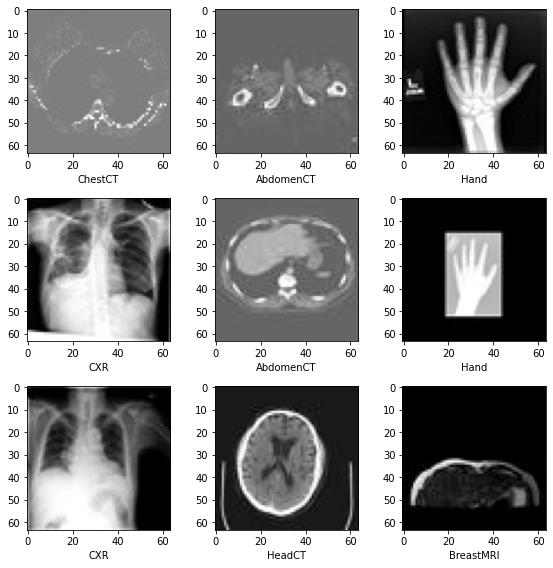

In [ ]:
mp.subplots(3,3,figsize=(8,8))
for i,k in enumerate(np.random.randint(numTotal, size=9)):  # Take a random sample of 9 images and
    im = Image.open(imageFilesList[k])                      #      plot and label them
    arr = np.array(im)
    mp.subplot(3,3,i+1)
    mp.xlabel(classNames[imageClass[k]])
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()


## Transforming Data and Partitioning into Training, Validation, and Testing Sets


In [ ]:
toTensor = tv.transforms.ToTensor()
def scaleImage(x):          # Pass a PIL image, return a tensor
    y = toTensor(x)
    if(y.min() < y.max()):  # Assuming the image isn't empty, rescale so its values run from 0 to 1
        y = (y - y.min())/(y.max() - y.min()) 
    z = y - y.mean()        # Subtract the mean value of the image
    return z


In [ ]:
# #Uncomment for EX.6
# toTensor = tv.transforms.ToTensor()
# def scaleImage(x):          # Pass a PIL image, return a tensor
#     y = toTensor(x)
#     if(y.min() < y.max()):  # Assuming the image isn't empty, rescale so its values run from 0 to 1
#         y = (y - y.min())/(y.max() - y.min()) 
#     # z = y - y.mean()        # Subtract the mean value of the image
#     z = y
#     return z

With the image-to-tensor transformation function defined, we now create a master tensor out of all these images. We also create a tensor for the labels. Execution of this code takes a moment. We double check the final range of scaled pixel values and verify that the mean is (practically) zero.


In [ ]:
imageTensor = torch.stack([scaleImage(Image.open(x)) for x in imageFilesList])  # Load, scale, and stack image (X) tensor
classTensor = torch.tensor(imageClass)  # Create label (Y) tensor
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"
      .format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))


Rescaled min pixel value = 0.0; Max = 1.0; Mean = 0.243


In [ ]:
validFrac = 0.1   # Define the fraction of images to move to validation dataset
testFrac = 0.1    # Define the fraction of images to move to test dataset
validList = []
testList = []
trainList = []

for i in range(numTotal):
    rann = np.random.random() # Randomly reassign images
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)
        
nTrain = len(trainList)  # Count the number in each set
nValid = len(validList)
nTest = len(testList)
print("Training images =",nTrain,"Validation =",nValid,"Testing =",nTest)



Training images = 47140 Validation = 5820 Testing = 5794


In [ ]:
trainIds = torch.tensor(trainList)    # Slice the big image and label tensors up into
validIds = torch.tensor(validList)    #       training, validation, and testing tensors
testIds = torch.tensor(testList)
trainX = imageTensor[trainIds,:,:,:]
trainY = classTensor[trainIds]
validX = imageTensor[validIds,:,:,:]
validY = classTensor[validIds]
testX = imageTensor[testIds,:,:,:]
testY = classTensor[testIds]


## Model Architecture

The details of the architecture are explained in the comments within the code, but here we give an overview of the two types of layers encountered.

The first is the <em>convolutional</em> layer. When interpreting an image, the eye first identifies edges and boundaries. Then, one can make out curves, shapes, and more complex structures at higher levels of abstraction. By only combining information from nearby pixels at first, a series of convolutional layers mimics this organic process. The size of the convolution is how many adjacent pixels are weighted and added up when moving to the next layer, and we can apply multiple convolutions to every pixel in an image (or in a higher layer). Pictured below is a single 3 × 3 convolution. The value of each pixel of the convolutional kernel - these are the weights that are trained - is multiplied with the corresponding pixel value within the neighborhood of the original, central image pixel. These products are summed up, and the total is placed in the central pixel (node, to use the nomenclature) of the new layer. The process is repeated for each pixel and each convolution within the layer. Several convolutional layers can be stacked on top of each other; this has the effect of finding increasingly complex features.


In [ ]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC): # Pass image dimensions and number of labels when initializing a model   
        super(MedNet,self).__init__()  # Extends the basic nn.Module to the MedNet class
        # The parameters here define the architecture of the convolutional portion of the CNN. Each image pixel
        # has numConvs convolutions applied to it, and convSize is the number of surrounding pixels included
        # in each convolution. Lastly, the numNodesToFC formula calculates the final, remaining nodes at the last
        # level of convolutions so that this can be "flattened" and fed into the fully connected layers subsequently.
        # Each convolution makes the image a little smaller (convolutions do not, by default, "hang over" the edges
        # of the image), and this makes the effective image dimension decreases.
        
        numConvs1 = 5
        convSize1 = 7
        numConvs2 = 10
        convSize2 = 7
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

        # nn.Conv2d(channels in, channels out, convolution height/width)
        # 1 channel -- grayscale -- feeds into the first convolution. The same number output from one layer must be
        # fed into the next. These variables actually store the weights between layers for the model.
        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

        # These parameters define the number of output nodes of each fully connected layer.
        # Each layer must output the same number of nodes as the next layer begins with.
        # The final layer must have output nodes equal to the number of labels used.
        
        fcSize1 = 400
        fcSize2 = 80
        
        # nn.Linear(nodes in, nodes out)
        # Stores the weights between the fully connected layers
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2,numC)

        self.drop1 = nn.Dropout(0.5)
        self.drop2 = nn.Dropout(0.4)
        
    def forward(self,x):
        # This defines the steps used in the computation of output from input.
        # It makes uses of the weights defined in the __init__ method.
        # Each assignment of x here is the result of feeding the input up through one layer.
        # Here we use the activation function elu, which is a smoother version of the popular relu function.
        
        x = F.elu(self.cnv1(x)) # Feed through first convolutional layer, then apply activation
        x = self.drop1(x)
        x = F.elu(self.cnv2(x)) # Feed through second convolutional layer, apply activation
        x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
        x = F.elu(self.ful1(x)) # Feed through first fully connected layer, apply activation

        
        x = self.drop2(self.ful2(x))
        x = F.elu(x)


        # x = F.elu(self.ful2(x)) # Feed through second FC layer, apply output
        x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
        return x

    def num_flat_features(self, x):  # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

With the architecture defined, we create an instance of the model. This single line is separated out so that we can continue or repeat the training code below without resetting the model from scratch, if needed.



In [ ]:
model = MedNet(imageWidth,imageHeight,numClass).to(dev)

## Training the Model

Now, it's time to train the model. The next code block does so.

First, we define the hyperparameters of the training. The learning rate reflects how much the model is updated per batch. If it is too small, the training proceeds slowly. If it's too large, the weights will be adjusted too much and miss the true minimum loss, or even become unstable. An epoch is a full run through the training data. Some models require thousands of epochs to train; this one will produce high accuracy with just a handful.

We use validation data to prevent overtraining in our model. The training and validation data are drawn from the same set of data; therefore, the model ought to have similar loss for both. Thus, we set a limit on how much larger the validation loss can be than the training loss. Because random fluctuation might account for some discrepancy, we require a few epochs pass with high validation loss before halting.



In [ ]:
# EX.1

# learnRate = 0.01          # Define a learning rate.
# maxEpochs = 20            # Maximum training epochs
# t2vRatio = 1.2          # Maximum allowed ratio of validation to training loss
# # t2vRatio = 1.8            #uncomment this for get result in Ex.1
# t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
# batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
# trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
# validBats = nValid // batchSize       # Validation batches. Round down
# testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
# CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
# for i in trainY.tolist():             #      By making rarer images count more to the loss, 
#     CEweights[i].add_(1)              #      we prevent the model from ignoring them.
# CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
# CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
# opti = om.SGD(model.parameters(), lr = learnRate)   # Initialize an optimizer


# for i in range(maxEpochs):
#     model.train()                     # Set model to training mode
#     epochLoss = 0.
#     permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
#     trainX = trainX[permute,:,:,:]
#     trainY = trainY[permute]
#     for j in range(trainBats):        # Iterate over batches
#         opti.zero_grad()              # Zero out gradient accumulated in optimizer
#         batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
#         batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
#         yOut = model(batX)            # Evalute predictions
#         loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
#         epochLoss += loss.item()      # Add loss
#         loss.backward()               # Backpropagate loss
#         opti.step()                   # Update model weights using optimizer
#     validLoss = 0.
#     permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
#     validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
#     validY = validY[permute]
#     model.eval()                      # Set model to evaluation mode
#     with torch.no_grad():             # Temporarily turn off gradient descent
#         for j in range(validBats):
#             opti.zero_grad()
#             batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
#             batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
#             yOut = model(batX)
#             validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
#     epochLoss /= trainBats            # Average loss over batches and print
#     validLoss /= validBats
#     print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
#     if validLoss > t2vRatio * epochLoss:
#         t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
#         if t2vEpochs < 1:
#             print("Validation loss too high; halting to prevent overfitting")
#             break
    

In [ ]:
#EX.2
# learnRate = 0.001          # Define a learning rate.
# maxEpochs = 20            # Maximum training epochs
# t2vRatio = 1.2          # Maximum allowed ratio of validation to training loss
# t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
# batchSize = 256           # Batch size. Going too large will cause an out-of-memory error.
# trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
# validBats = nValid // batchSize       # Validation batches. Round down
# testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
# CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
# for i in trainY.tolist():             #      By making rarer images count more to the loss, 
#     CEweights[i].add_(1)              #      we prevent the model from ignoring them.
# CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
# CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
# opti = om.SGD(model.parameters(), lr = learnRate)   # Initialize an optimizer


# for i in range(maxEpochs):
#     model.train()                     # Set model to training mode
#     epochLoss = 0.
#     permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
#     trainX = trainX[permute,:,:,:]
#     trainY = trainY[permute]
#     for j in range(trainBats):        # Iterate over batches
#         opti.zero_grad()              # Zero out gradient accumulated in optimizer
#         batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
#         batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
#         yOut = model(batX)            # Evalute predictions
#         loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
#         epochLoss += loss.item()      # Add loss
#         loss.backward()               # Backpropagate loss
#         opti.step()                   # Update model weights using optimizer
#     validLoss = 0.
#     permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
#     validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
#     validY = validY[permute]
#     model.eval()                      # Set model to evaluation mode
#     with torch.no_grad():             # Temporarily turn off gradient descent
#         for j in range(validBats):
#             opti.zero_grad()
#             batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
#             batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
#             yOut = model(batX)
#             validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
#     epochLoss /= trainBats            # Average loss over batches and print
#     validLoss /= validBats
#     print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
#     if validLoss > t2vRatio * epochLoss:
#         t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
#         if t2vEpochs < 1:
#             print("Validation loss too high; halting to prevent overfitting")
#             break

In [ ]:
# # Ex.3 and Ex.4
# learnRate = 0.01          # Define a learning rate.
# maxEpochs = 20            # Maximum training epochs
# t2vRatio = 1.2          # Maximum allowed ratio of validation to training loss
# t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
# batchSize = 256           # Batch size. Going too large will cause an out-of-memory error.
# trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
# validBats = nValid // batchSize       # Validation batches. Round down
# testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
# CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
# for i in trainY.tolist():             #      By making rarer images count more to the loss, 
#     CEweights[i].add_(1)              #      we prevent the model from ignoring them.
# CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
# CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
# opti = om.SGD(model.parameters(), lr = learnRate)   # Initialize an optimizer


# for i in range(maxEpochs):
#     model.train()                     # Set model to training mode
#     epochLoss = 0.
#     permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
#     trainX = trainX[permute,:,:,:]
#     trainY = trainY[permute]
#     for j in range(trainBats):        # Iterate over batches
#         opti.zero_grad()              # Zero out gradient accumulated in optimizer
#         batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
#         batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
#         yOut = model(batX)            # Evalute predictions
#         loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
#         epochLoss += loss.item()      # Add loss
#         loss.backward()               # Backpropagate loss
#         opti.step()                   # Update model weights using optimizer
#     validLoss = 0.
#     permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
#     validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
#     validY = validY[permute]
#     model.eval()                      # Set model to evaluation mode
#     with torch.no_grad():             # Temporarily turn off gradient descent
#         for j in range(validBats):
#             opti.zero_grad()
#             batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
#             batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
#             yOut = model(batX)
#             validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
#     epochLoss /= trainBats            # Average loss over batches and print
#     validLoss /= validBats
#     print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
#     if validLoss > t2vRatio * epochLoss:
#         t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
#         if t2vEpochs < 1:
#             print("Validation loss too high; halting to prevent overfitting")
#             break

In [ ]:
# Ex.5, 6, 7
learnRate = 0.01          # Define a learning rate.
maxEpochs = 20            # Maximum training epochs
t2vRatio = 1.2          # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 256           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValid // batchSize       # Validation batches. Round down
testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.SGD(model.parameters(), lr = learnRate)   # Initialize an optimizer
CEweights = torch.ones(numClass).to(dev)

for i in range(maxEpochs):
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
    if validLoss > t2vRatio * epochLoss:
        t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
        if t2vEpochs < 1:
            print("Validation loss too high; halting to prevent overfitting")
            break

Epoch =   0; Training loss = 0.2210; Validation loss = 0.0561
Epoch =   1; Training loss = 0.0696; Validation loss = 0.0373
Epoch =   2; Training loss = 0.0504; Validation loss = 0.0277
Epoch =   3; Training loss = 0.0410; Validation loss = 0.0249
Epoch =   4; Training loss = 0.0318; Validation loss = 0.0233
Epoch =   5; Training loss = 0.0292; Validation loss = 0.0185
Epoch =   6; Training loss = 0.0239; Validation loss = 0.0171
Epoch =   7; Training loss = 0.0230; Validation loss = 0.0162
Epoch =   8; Training loss = 0.0209; Validation loss = 0.0148
Epoch =   9; Training loss = 0.0195; Validation loss = 0.0177
Epoch =  10; Training loss = 0.0174; Validation loss = 0.0114
Epoch =  11; Training loss = 0.0155; Validation loss = 0.0115
Epoch =  12; Training loss = 0.0140; Validation loss = 0.0120
Epoch =  13; Training loss = 0.0145; Validation loss = 0.0106
Epoch =  14; Training loss = 0.0132; Validation loss = 0.0101
Epoch =  15; Training loss = 0.0122; Validation loss = 0.0094
Epoch = 


## Testing the Model on New Data

With the model fully trained, it's time to apply it to generate predictions from the test dataset. 

In [ ]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest)
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)


Correct predictions:  5775 of 5794
Confusion Matrix:
[[901   0   0   0   0   0]
 [  0 968   0   0   0   4]
 [  0   0 988   0   5   0]
 [  0   1   0 985   1   1]
 [  0   1   4   1 995   0]
 [  0   1   0   0   0 938]]
['BreastMRI', 'AbdomenCT', 'CXR', 'HeadCT', 'Hand', 'ChestCT']




Before we get to the exercises, let's take a look at some of the images that confused the model. This cell can be rerun to produce more examples.




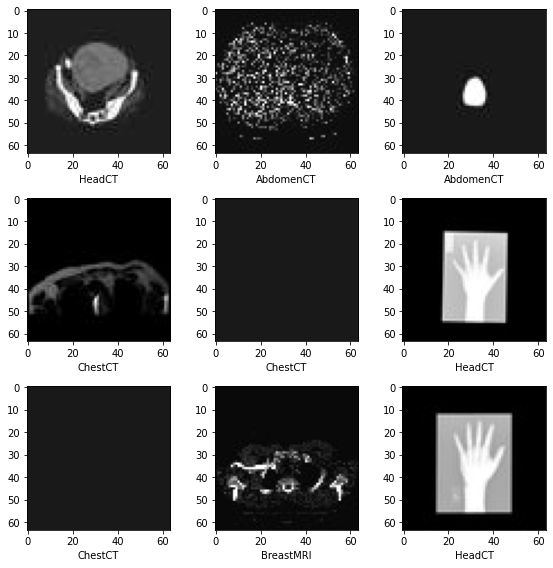

In [ ]:
def scaleBack(x):               # Pass a tensor, return a numpy array from 0 to 1
    if(x.min() < x.max()):      # Assuming the image isn't empty, rescale so its values run from 0 to 1
        x = (x - x.min())/(x.max() - x.min())
    return x[0].to(cpu).numpy() # Remove channel (grayscale anyway)

model.eval()
mp.subplots(3,3,figsize=(8,8))
imagesLeft = 9
permute = torch.randperm(nTest)        # Shuffle test data
testX = testX[permute,:,:,:]
testY = testY[permute]
for j in range(testBats):              # Iterate over test batches
    batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
    batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
    yOut = model(batX)                 # Pass test batch through model
    pred = yOut.max(1)[1].tolist()     # Generate predictions by finding the max Y values
    for i, y in enumerate(batY.tolist()):
        if imagesLeft and y != pred[i]:         # Compare the actual y value to the prediction
            imagesLeft -= 1
            mp.subplot(3,3,9-imagesLeft)
            mp.xlabel(classNames[pred[i]])      # Label image with what the model thinks it is
            mp.imshow(scaleBack(batX[i]),cmap='gray',vmin=0,vmax=1)
mp.tight_layout()
mp.show()
    
    

In [ ]:
pwd

'/content'

In [ ]:
ls

drive/  MedMnist/  sample_data/  saved_model


In [ ]:
torch.save(model, 'saved_model')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type MedNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Some of these images are indeed confusing, even for a human observer. 

## Exercises

It may be useful to restart the kernel (under Kernel menu) to clear the memory between exercises, or even to copy the notebook (under File menu) and do each exercise in a clean copy. Because time may be limited, scan through the exercises and start with the ones that most appeal to you. Exercises 1, 2, and 3 are particularly recommended if you are new to deep learning.

<ol>
    <li>Without resetting the kernel, increase <code>t2vRatio</code> in code block 10 and continue the training. Can you improve the final accuracy observed on the test dataset this way? If so, does it improve as much as the change in training loss would seem to indicate? What might this suggest about the relative value of architecting to training?</li><hr>
        <li>Reset the model by running code block 9, then modify the hyperparameters and retraing the model in code block 10. The most interesting ones are the learning rate (larger or smaller) and the batch size (smaller works well; when increasing the batch size, you will run out of memory somewhere in the low thousands). Note the effects on training. Can you make it converge faster than the default values?</li><hr>
    <li>Modify the architecture in code block 8 and note the effects on the training speed and final accuracy
        <ol>
            <li> Easy: Change the number of convolutions, the size of the convolutions, and the number of fully connected layers</li>
            <li> Medium: Add additional convolutional and/or fully connected layers. Use the existing code for reference.</li>
            <li> Hard: Add <a href="https://pytorch.org/docs/stable/_modules/torch/nn/modules/batchnorm.html#BatchNorm1d">batchnorm</a>, <a href="https://pytorch.org/docs/stable/_modules/torch/nn/modules/pooling.html#MaxPool2d">maxpool</a>, and/or <a href="https://pytorch.org/docs/stable/_modules/torch/nn/modules/dropout#Dropout">dropout</a> layers.</li>
        </ol>
    </li><hr>
    <li>Unbalance the classes. This is a common problem in medical imaging, and can be done by adding a single line of code in code block 2: <code>imageFiles[5] = imageFiles[5][:-NNN]</code> where <code>NNN</code> is the number images from the final class to remove. You could also replace the 5 with 0 - 4, instead. Insert this line between <code>imageFiles = ...</code> and <code>numEach = ...</code> How small of a set can you have while still getting good results for this class in the confusion matrix? This exercise combines well with the next one.</li><hr>
    <li>Remove the weights for the loss function by adding <code>CEweights = torch.ones(numClass).to(dev)</code> after the line <code>opti = ...</code> in code block 10. What effect does this have in the confusion matrix when identifying the rarer image class? You could also implement custom weights by using <code>CEweights = torch.tensor([a,b,c,d,e,f]).to(dev)</code> where <code>a ... f</code> are floating point numbers. In this case, note the effects of having one or more relatively large weights.</li><hr>
    <li>Remove one or both of the modifications to the tensor from code block 4. Note the effects on the early training and final accuracy.</li><hr>
    <li><b>Final challenge:</b>By using experience gained from the previous exercises, you can adjust the architecture and training to make a more accurate final model. Can your improved model make fewer than 10 mistakes on the testing set?</li>
</ol>



## Solutions


**Show default result before model modification for  results difference comparison:**

Epoch =   0; Training loss = 0.6760; Validation loss = 0.2390

Epoch =   1; Training loss = 0.1861; Validation loss = 0.1567

Epoch =   2; Training loss = 0.1246; Validation loss = 0.1011

Epoch =   3; Training loss = 0.0864; Validation loss = 0.0728

Epoch =   4; Training loss = 0.0629; Validation loss = 0.0512

Epoch =   5; Training loss = 0.0484; Validation loss = 0.0446

Epoch =   6; Training loss = 0.0387; Validation loss = 0.0330

Epoch =   7; Training loss = 0.0317; Validation loss = 0.0270

Epoch =   8; Training loss = 0.0266; Validation loss = 0.0240

Epoch =   9; Training loss = 0.0237; Validation loss = 0.0223

Epoch =  10; Training loss = 0.0201; Validation loss = 0.0203

Epoch =  11; Training loss = 0.0175; Validation loss = 0.0174

Epoch =  12; Training loss = 0.0153; Validation loss = 0.0151

Epoch =  13; Training loss = 0.0138; Validation loss = 0.0160

Epoch =  14; Training loss = 0.0124; Validation loss = 0.0136


Epoch =  15; Training loss = 0.0113; Validation loss = 0.0129

Epoch =  16; Training loss = 0.0100; Validation loss = 0.0117

Epoch =  17; Training loss = 0.0093; Validation loss = 0.0120

Epoch =  18; Training loss = 0.0084; Validation loss = 0.0112

Epoch =  19; Training loss = 0.0078; Validation loss = 0.0113

Validation loss too high; halting to prevent overfitting

**Correct predictions**:  5718 of 5740

**Confusion Matrix**:

 
 [ 858    0    0    0    0    0]

 [   0 1010    0    0    0    2]
 
 [   0    0  988    0    3    1]
 
 [   1    0    0  962    0    0]
 
 [   0    0    4    2  933    0]
 
 [   1    8    0    0    0  967]

## Ex.1

For t2vRatio = 1.8 we have this results:
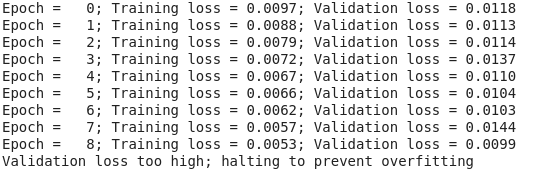





Correct predictions:  5721 of 5740.

Therefore, validation loss has decreased and the accuracy of the model has increased

## Ex.2

We change learnRate = 0.001 and batchSize = 256 and get overfitting for third epoch.

Epoch =   0; Training loss = 0.0055; Validation loss = 0.0101
Epoch =   1; Training loss = 0.0054; Validation loss = 0.0073
Epoch =   2; Training loss = 0.0054; Validation loss = 0.0097
Validation loss too high; halting to prevent overfitting

**Correct predictions**:  5723 of 5740

**Confusion Matrix**:

[ 858    0    0    0    0    0]

[   0 1009    0    0    0    3]

[   0    0  989    0    2    1]

[   1    0    0  962    0    0]

[   0    0    4    2  933    0]

[   1    3    0    0    0  972]        

**Сonclusion:this neural network frequently overfitting and we need to apply technic for avoid overfitting. For example we can add dropout layer(see Ex.3)** 

## Ex.3

**Results fter apply one dropout layer with delete 50%**

Epoch =   0; Training loss = 0.6457; Validation loss = 0.1849

Epoch =   1; Training loss = 0.1443; Validation loss = 0.1088

Epoch =   2; Training loss = 0.0901; Validation loss = 0.0619

Epoch =   3; Training loss = 0.0599; Validation loss = 0.0441

Epoch =   4; Training loss = 0.0454; Validation loss = 0.0361

Epoch =   5; Training loss = 0.0361; Validation loss = 0.0256

Epoch =   6; Training loss = 0.0287; Validation loss = 0.0221

Epoch =   7; Training loss = 0.0258; Validation loss = 0.0195

Epoch =   8; Training loss = 0.0213; Validation loss = 0.0180

Epoch =   9; Training loss = 0.0193; Validation loss = 0.0141

Epoch =  10; Training loss = 0.1833; Validation loss = 0.0341

Epoch =  11; Training loss = 0.0304; Validation loss = 0.0235

Epoch =  12; Training loss = 0.0223; Validation loss = 0.0172

Epoch =  13; Training loss = 0.0186; Validation loss = 0.0140

Epoch =  14; Training loss = 0.0158; Validation loss = 0.0129

Epoch =  15; Training loss = 0.0138; Validation loss = 0.0119

Epoch =  16; Training loss = 0.0122; Validation loss = 0.0111

Epoch =  17; Training loss = 0.0109; Validation loss = 0.0099

Epoch =  18; Training loss = 0.0103; Validation loss = 0.0095

Epoch =  19; Training loss = 0.0094; Validation loss = 0.0097


**Correct predictions**:  5720 of 5740

**Confusion Matrix**:

[ 858    0    0    0    0    0]

[   0 1010    0    0    0    2]

[   1    0  989    1    1    0]

[   0    0    0  961    2    0]

[   0    0    6    3  930    0]

[   1    3    0    0    0  972]

After add more one dropout layer with delete 25%, result stay similarly.

## Ex.4


**Results for NNN = 200:**

Epoch =   0; Training loss = 0.7179; Validation loss = 0.2150

Epoch =   1; Training loss = 0.1813; Validation loss = 0.1233

Epoch =   2; Training loss = 0.1133; Validation loss = 0.0813

Epoch =   3; Training loss = 0.0787; Validation loss = 0.0660

Epoch =   4; Training loss = 0.0591; Validation loss = 0.0508

Epoch =   5; Training loss = 0.0497; Validation loss = 0.0410

Epoch =   6; Training loss = 0.0417; Validation loss = 0.0476

Epoch =   7; Training loss = 0.0357; Validation loss = 0.0300

Epoch =   8; Training loss = 0.0308; Validation loss = 0.0286

Epoch =   9; Training loss = 0.0269; Validation loss = 0.0286

Epoch =  10; Training loss = 0.0251; Validation loss = 0.0232

Epoch =  11; Training loss = 0.0228; Validation loss = 0.0213

Epoch =  12; Training loss = 0.0215; Validation loss = 0.0213

Epoch =  13; Training loss = 0.0196; Validation loss = 0.0187

Epoch =  14; Training loss = 0.0191; Validation loss = 0.0206

Epoch =  15; Training loss = 0.0174; Validation loss = 0.0262

Epoch =  16; Training loss = 0.0158; Validation loss = 0.0162

Epoch =  17; Training loss = 0.0152; Validation loss = 0.0158

Epoch =  18; Training loss = 0.0140; Validation loss = 0.0146

Epoch =  19; Training loss = 0.0133; Validation loss = 0.0143

**Correct predictions:**  5784 of 5809 =99,57%
**Confusion Matrix:**

[867   0   0   0   0   0]

[  0 988   0   0   0   8]

[  0   0 997   0   6   1]

[  0   2   0 969   3   1]

[  0   0   1   0 985   0]

[  0   3   0   0   0 978]


In [ ]:
For NNN = 400, the model accuracy becomes worse.

## Ex.5

**Correct predictions**:  5796 of 5811 = 99,74%

**The accuracy of the model has increased!!!**

Confusion Matrix:
[ 882    0    0    0    0    0]

[   0 1026    0    0    0    2]

[   0    0  931    0    6    0]

[   0    0    0 1020    0    0]

[   0    1    1    3  996    0]

[   0    2    0    0    0  941]


Epoch =   0; Training loss = 0.6402; Validation loss = 0.1744

Epoch =   1; Training loss = 0.1605; Validation loss = 0.1001

Epoch =   2; Training loss = 0.0995; Validation loss = 0.0615

Epoch =   3; Training loss = 0.0712; Validation loss = 0.0456

Epoch =   4; Training loss = 0.0555; Validation loss = 0.0365

Epoch =   5; Training loss = 0.0452; Validation loss = 0.0294

Epoch =   6; Training loss = 0.0394; Validation loss = 0.0261

Epoch =   7; Training loss = 0.0346; Validation loss = 0.0226

Epoch =   8; Training loss = 0.0307; Validation loss = 0.0206

Epoch =   9; Training loss = 0.0267; Validation loss = 0.0201

Epoch =  10; Training loss = 0.0246; Validation loss = 0.0169

Epoch =  11; Training loss = 0.0228; Validation loss = 0.0148

Epoch =  12; Training loss = 0.0203; Validation loss = 0.0168

Epoch =  13; Training loss = 0.0189; Validation loss = 0.0132

Epoch =  14; Training loss = 0.0175; Validation loss = 0.0128

Epoch =  15; Training loss = 0.0165; Validation loss = 0.0113

Epoch =  16; Training loss = 0.0150; Validation loss = 0.0117

Epoch =  17; Training loss = 0.0146; Validation loss = 0.0100

Epoch =  18; Training loss = 0.0130; Validation loss = 0.0099

Epoch =  19; Training loss = 0.0124; Validation loss = 0.0097


## Ex.6

Epoch =   0; Training loss = 0.5598; Validation loss = 0.1316

Epoch =   1; Training loss = 0.1322; Validation loss = 0.0816

Epoch =   2; Training loss = 0.0787; Validation loss = 0.0406

Epoch =   3; Training loss = 0.0774; Validation loss = 0.0321

Epoch =   4; Training loss = 0.0471; Validation loss = 0.0238

Epoch =   5; Training loss = 0.0383; Validation loss = 0.0271

Epoch =   6; Training loss = 0.0323; Validation loss = 0.0204

Epoch =   7; Training loss = 0.0273; Validation loss = 0.0229

Epoch =   8; Training loss = 0.0243; Validation loss = 0.0148

Epoch =   9; Training loss = 0.0228; Validation loss = 0.0160

Epoch =  10; Training loss = 0.0198; Validation loss = 0.0136

Epoch =  11; Training loss = 0.0167; Validation loss = 0.0131

Epoch =  12; Training loss = 0.0169; Validation loss = 0.0112

Epoch =  13; Training loss = 0.0157; Validation loss = 0.0128

Epoch =  14; Training loss = 0.0137; Validation loss = 0.0091

Epoch =  15; Training loss = 0.0132; Validation loss = 0.0099

Epoch =  16; Training loss = 0.0147; Validation loss = 0.0115

Epoch =  17; Training loss = 0.0113; Validation loss = 0.0126

Epoch =  18; Training loss = 0.0103; Validation loss = 0.0092

Epoch =  19; Training loss = 0.0105; Validation loss = 0.0108


**Correct predictions:** 5775 of 5794 =   99,67 %

**The accuracy of the model has decreased compared to the previous model Ex.5**

**Confusion Matrix:**

 [901   0   0   0   0   0]
 
 [  0 970   0   0   0   2]
 
 [  0   0 988   2   3   0]
 
 [  0   1   0 985   1   1]
 
 [  0   1   5   2 993   0]
 
 [  0   1   0   0   0 938]